# <center> Проект №5. Компьютер говорит нет.

Добрый день. Вашему вниманию представлен проект по машинному обучению.    
Задача проекта - построить скоринг модель для клиентов банка, которая будет предсказывать вероятность дефолта клиента. 

Работу подготовил: Жданович Владислав Геннадьевич

Для начала, импортируем все библиотеки.

In [64]:
import numpy as np
import pandas as pd
import math
from datetime import datetime


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option("display.max_columns", None)

In [2]:
# Вынесем функцию которую будем использовать
# для обработки бинарных и категориальных переменных
def show_information(col):
    '''Функция принимает список признаков, и по каждому 
    признаку выводит уникальные значения, общее количество,
    процентное отношение дефолтных клиентов в каждом уникальном
    значении и строит catplot'''
    for i in col:
        total = df[i].value_counts()
        num_ = total.count()
        print('Признак - ', i)
        print('Уникальные значения - ', df[i].unique())
    # Выведем общее количество значений по группе
        print('общее количество значений по группе')
        print(total)
        group_count = df[[i, 'default', 'client_id']].groupby(
            [i, 'default']).count()
    # т.к. у нас выборка несбалансированная, для более корректного анализа
    # узнаем процентное соотношение дефолтных клиентов между группами
        sns.catplot(data=df, kind="count", x=i, hue="default",
                    ci="sd", palette="dark", alpha=.6, height=6)
        plt.show()
        # Выведем вероятность деволта по каждому значению
        print("Процент дефолта по категории")
        for x in range(0, num_*2, 2):
            index = (group_count.index[x], group_count.index[x+1])
            total_2 = group_count.iloc[x]+group_count.iloc[x+1]
            num = (group_count.iloc[x][0], group_count.iloc[x+1][0])
            plt.pie(num, autopct='%1.2f%%')
            plt.legend(index,
                       loc="center left",
                       bbox_to_anchor=(1, 0, 0.5, 1))
            plt.show()


def show_num_information(num_cols):
    '''Функция принимает на вход название количественного признака
    и выводи всю описательную статистику.'''
    print(f'вывод информации по признаку {num_cols}')
    print('Мода - ', df[num_cols].mode()[0])
    print(df[num_cols].describe())
    sns.boxplot(data=df, x='default', y=num_cols)
    plt.show()
    sns.distplot(df[num_cols], kde=False, rug=False)
    plt.title(num_cols)
    plt.show()

# функция для вывода f_classif
def print_f_classif(data, col):
    '''Функция для вывода f_classif по заданным столбцам
    data - датафрейм
    col - признаки по которым будут проходит сравнения
    '''
    imp_num2 = pd.Series(f_classif(data[col], data['default'])[0], index=col)
    imp_num2.sort_values(inplace=True)
    imp_num2.plot(kind='barh')

# Функция для вывода корреляционной матрицы.
def print_corr_matrix(cor_matrix, limit=0.5):
    '''Функция для вывода корреляционной матрицы и указанием сильной корреляции
    corr_matrix - Корреляционная матрица
    limit - минимальная корреляция. По умолчанию 0.5'''
    sns.heatmap(cor_matrix)
    cof = 0
    for x in cor_matrix.columns:
        cof += 1
        for y in cor_matrix.index[cof:]:
            if abs(cor_matrix[x][y]) > 0.5:
                print(
                    f'Сильная корреляция между {x} and {y} - {cor_matrix.loc[x][y]}')

In [3]:
# функция которая выводит все наши метрики.
def print_roc_curve(y_test, y_train):
    fpr, tpr, threshold = roc_curve(y_test, y_train)
    roc_auc = roc_auc_score(y_test, y_train)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [4]:
# Функция для вывода confusion_matrix
# Спасибо за идею The A-Team
def make_confusion_matrix(cf,
                          group_names=['TN', 'FP', 'FN', 'TP'],
                          categories='auto',
                          sum_stats=True,
                          count=True,
                          cbar=True,
                          percent=True,
                          cmap='BuPu'):
    '''Function is called for making a confusion matrix
    args
    ------
    cf - confusion matrix
    group_names - Names for each group
    categories -  categories to be displayed on the x,y axis. Default is 'auto'
    sum_stats -   shows Accuracies. Deafult is TRUE
    c_bar -       If True, show the color bar. The cbar values are based off the values in the confusion matrix. 
                  Default is True
    percent -     to be displayed on the x,y axis. Default is True
    '''
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    group_labels = ["{}\n".format(value) for value in group_names]

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [
            "{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)
        ]
    else:
        group_percentages = blanks

    box_labels = [
        f"{v1}{v2}{v3}".strip()
        for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # Metrics
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))
        ball_accuracy = .5 * (cf[1, 1] / sum(cf[1, :]) +
                              cf[0, 0] / sum(cf[0, :]))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # pr = how many real true
            precision = cf[1, 1] / sum(cf[:, 1])
            # How many positives from all positives
            recall = cf[1, 1] / sum(cf[1, :])
            # F1 score
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nBallancedAcc={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, ball_accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    plt.rcParams.get('figure.figsize')
    plt.figure(figsize=(5, 5))
    sns.heatmap(cf,
                annot=box_labels,
                fmt="",
                cmap=cmap,
                cbar=cbar,
                xticklabels=categories,
                yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)

# Раздел 1. Знакомство с датасетом.

Вспомним описания полей:   
client_id - идентификатор клиента    
app_date - дата подачи заявки      
education - уровень образования    
sex - пол заемщика    
age - возраст заемщика    
car - флаг наличия автомобиля    
car_type - флаг автомобиля иномарки    
decline_app_cnt - количество отказанных прошлых заявок    
good_work - флаг наличия “хорошей” работы    
bki_request_cnt - количество запросов в БКИ    
home_address - категоризатор домашнего адреса    
work_address - категоризатор рабочего адреса    
income - доход заемщика    
foreign_passport - наличие загранпаспорта    
sna - связь заемщика с клиентами банка    
first_time - давность наличия информации о заемщике    
score_bki - скоринговый балл по данным из БКИ    
region_rating - рейтинг региона       
default - флаг дефолта по кредиту

In [5]:
# загрузка данных при работе с Kaggle
#DATA_DIR = '/kaggle/input/sf-dst-scoring/'
#df_test = pd.read_csv(DATA_DIR+'test.csv')
#df_train = pd.read_csv(DATA_DIR+'train.csv')

In [6]:
#Загрузка данных при работе с офлайн
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [7]:
# Для корректной обработки объединяем данные
df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['default'] = 0 

df = df_test.append(df_train, sort=False).reset_index(drop=True)

### Быстренько познакомимся с данными

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [9]:
df.sample(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
28533,10308,17JAN2014,SCH,F,58,N,N,0,0,-3.145233,1,40,1,2,5400,1,3,N,0,0
14653,38190,14FEB2014,UGR,M,27,N,N,0,0,-2.354714,6,40,1,2,20000,2,3,N,0,0
98734,20141,27JAN2014,GRD,M,29,Y,N,0,0,-1.505461,3,50,1,3,40000,1,3,N,1,1
61954,56040,04MAR2014,SCH,F,56,Y,N,0,0,-1.782145,5,40,2,3,50000,1,2,N,1,0
80972,52263,28FEB2014,UGR,M,31,Y,Y,1,0,-1.177858,4,80,2,3,60000,2,3,N,1,0
79447,67962,17MAR2014,SCH,F,36,N,N,0,0,-1.916841,3,40,1,1,30000,1,3,N,1,0
54954,22799,30JAN2014,SCH,F,22,N,N,0,0,-2.225004,0,50,2,3,18000,4,1,N,1,0
12069,24136,31JAN2014,UGR,F,27,N,N,0,1,-1.833711,0,40,2,3,25000,1,3,N,0,0
11026,6178,13JAN2014,SCH,F,48,Y,Y,0,0,-2.102288,2,50,1,2,47500,1,3,N,0,0
1713,27919,04FEB2014,SCH,M,46,Y,Y,0,0,-2.309968,2,60,2,3,55000,4,1,N,0,0


In [10]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.669999,0.085086
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.470215,0.279010
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


Видим, что пропуски есть только в признаке education. Обработаем их чуть позже.  
В дата сете присутствуют как бинарные, категориальные и количественные признаки.    
Так же у нас есть дата, надо будет преобразовать данный признак в понятный для алгоритма признак.

Для упрощения анализа на следующих этапах, сразу рассортируем наши признаки.    
Сразу найдем количество уникальных значений в каждом признаки.

In [11]:
bin_cols = []
cat_cols = []
num_cols = []
new_cat_cols = [] # сюда будем категориальные сохранять признаки, которые мы создали
col_for_drop = [] # здесь будем сохранять признаки которые надо удалить

In [12]:
# отсортируем наши признаки
for i in df.iloc[:, 2:-2]:
    n_unique = df[i].nunique()
    print(f'Признак {i} содержит {n_unique} уникальных значений')
    if n_unique == 2:
        print(f'Признак {i} - бинарная переменная')
        bin_cols.append(i)
    elif n_unique > 2 and n_unique < 6:
        print(f'Признак {i} - категориальная переменная')
        cat_cols.append(i)
    elif n_unique >= 6:
        print(f'Признак {i} - количественная переменная')
        num_cols.append(i)

Признак education содержит 5 уникальных значений
Признак education - категориальная переменная
Признак sex содержит 2 уникальных значений
Признак sex - бинарная переменная
Признак age содержит 52 уникальных значений
Признак age - количественная переменная
Признак car содержит 2 уникальных значений
Признак car - бинарная переменная
Признак car_type содержит 2 уникальных значений
Признак car_type - бинарная переменная
Признак decline_app_cnt содержит 24 уникальных значений
Признак decline_app_cnt - количественная переменная
Признак good_work содержит 2 уникальных значений
Признак good_work - бинарная переменная
Признак score_bki содержит 102618 уникальных значений
Признак score_bki - количественная переменная
Признак bki_request_cnt содержит 40 уникальных значений
Признак bki_request_cnt - количественная переменная
Признак region_rating содержит 7 уникальных значений
Признак region_rating - количественная переменная
Признак home_address содержит 3 уникальных значений
Признак home_address

# Раздел 2. Строим наивную модель

In [13]:
df_naiv = df_train.copy()

In [14]:

label_encoder = LabelEncoder()
df_naiv['education'] = label_encoder.fit_transform(df_naiv['education'])
for i in bin_cols:
    df_naiv[i] = label_encoder.fit_transform(df_naiv[i])

In [15]:
#  разабьем наш дата сет
X = df_naiv.iloc[:, 2:-1]
Y = df_naiv['default']
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)

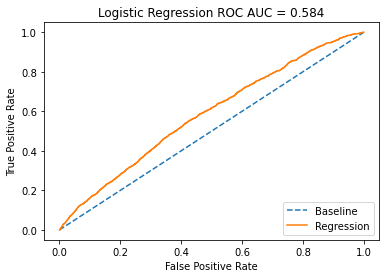

In [16]:
# построим сразу roc_curve
model_naiv = LogisticRegression()
model_naiv.fit(X_train, y_train)

probs = model_naiv.predict_proba(X_test)
probs = probs[:, 1]

print_roc_curve(y_test, probs)

In [17]:
# для того что бы посмотреть другие метрики, преобразуем полученный результат
y_bin_pred = model_naiv.predict(X_test)

<ipython-input-4-300fae532a82>:55: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = cf[1, 1] / sum(cf[:, 1])


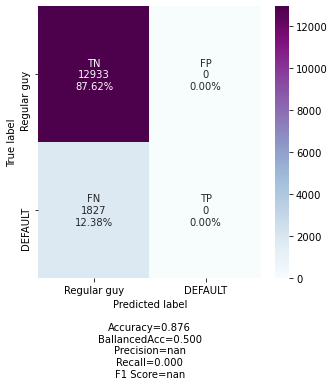

In [18]:
categories = ['Regular guy', 'DEFAULT']
cf_matrix = confusion_matrix(y_test, y_bin_pred)
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)

Метрика Accuracy показывает весьма хороший результат, однако он достигается за счет того, что наша модель выдает кредит всем.
Судя по сбалансированной точности и roc кривой, точность построенной модели немного лучше, чем выдача кредитов на основе подбрасывания монетки.    
Метрики Pricision и Recall вообще не отображаются, т.к. у нас отсутствуют данные по правильно отобранных дефолтных клиентах. 
p.s. в целом намешало бы использовать метрику прибыльности, описанную в статье (https://www.osp.ru/os/2020/03/13055545), но у нас нет данных потерь при дефолте.
Так же я бы ещё выделил клиентов, которые находиться в зоне риска (у которых вероятность вернуть кредит небольшая), и поставил бы им ограничения по сумме, чтобы уменьшить возможные потери.

# Раздел 3. Обработка пропусков

Так как у нас всего 478 пропусков в колонке education, а это примерно 0,4% от всех данных, заполним данный признак модой. Это не сильно испортит на наших данных.

In [19]:
# Отметим данные где есть пропуски
df["is_null_education"] = df.education.isnull().astype(int)
df.education = df.education.fillna(df.education.mode()[0])

# Раздел 4. Обработка банирных признаков.

В данном разделе мы рассмотрим признаки, которые мы отнесли к бинарным.

In [20]:
print('К бинарным признакам мы отнесли', bin_cols)

К бинарным признакам мы отнесли ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']


Признак -  sex
Уникальные значения -  ['M' 'F']
общее количество значений по группе
F    61836
M    48312
Name: sex, dtype: int64


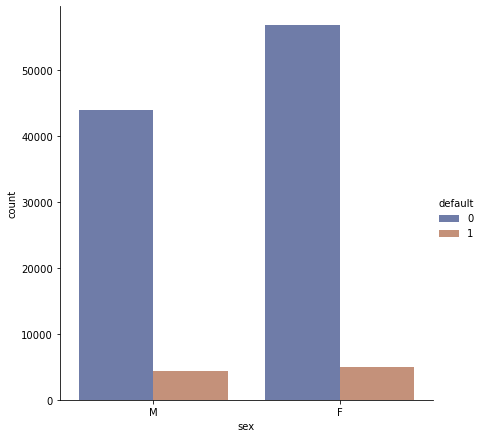

Процент дефолта по категории


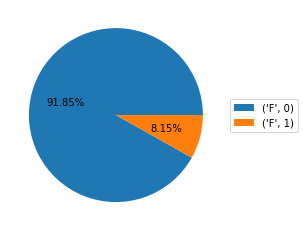

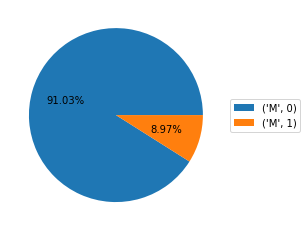

Признак -  car
Уникальные значения -  ['Y' 'N']
общее количество значений по группе
N    74290
Y    35858
Name: car, dtype: int64


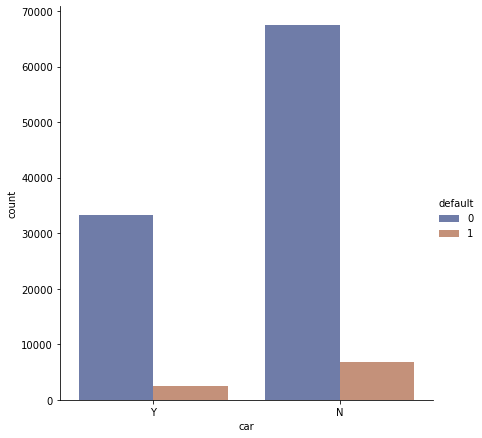

Процент дефолта по категории


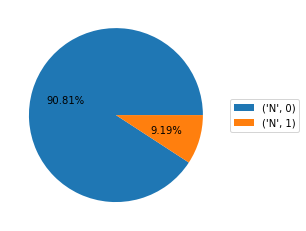

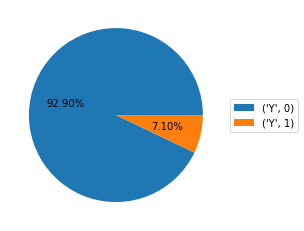

Признак -  car_type
Уникальные значения -  ['Y' 'N']
общее количество значений по группе
N    89140
Y    21008
Name: car_type, dtype: int64


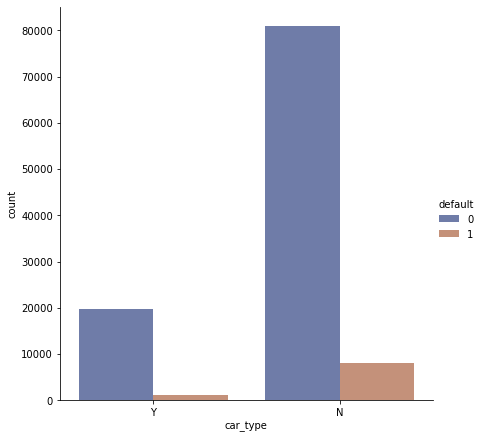

Процент дефолта по категории


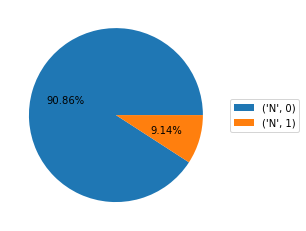

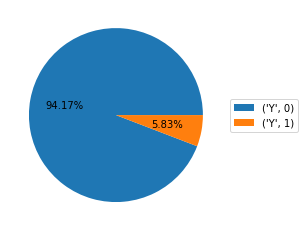

Признак -  good_work
Уникальные значения -  [0 1]
общее количество значений по группе
0    91917
1    18231
Name: good_work, dtype: int64


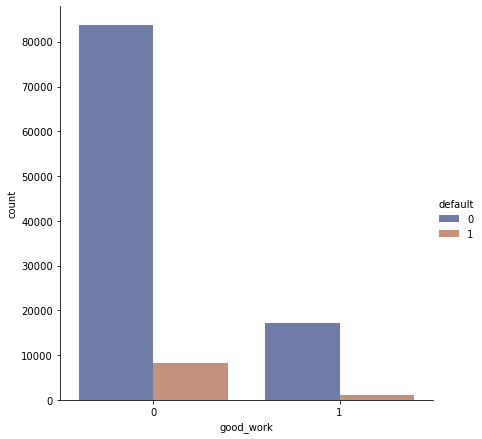

Процент дефолта по категории


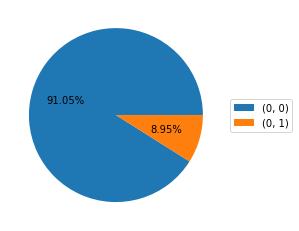

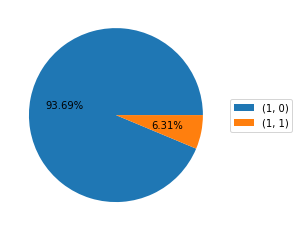

Признак -  foreign_passport
Уникальные значения -  ['N' 'Y']
общее количество значений по группе
N    93721
Y    16427
Name: foreign_passport, dtype: int64


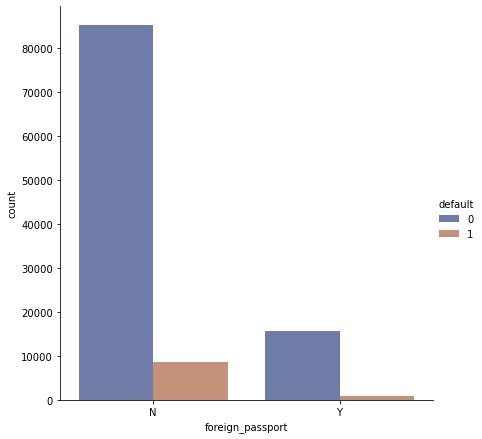

Процент дефолта по категории


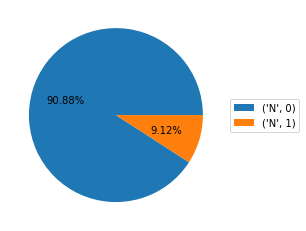

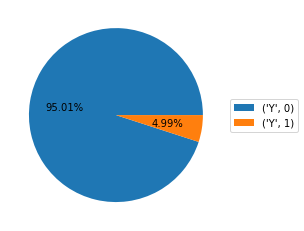

In [21]:
show_information(bin_cols)

## Вывод:    
В целом, ярко выраженная несбалансированность выборки.    
В дата сете представлено больше женщин.    
У большинства нет машин, а из людей, у которых есть машины, большинство владеет отечественными автомобилями.     
Мало у кого в нашем дата сете есть хорошая работа и есть загран паспорт.

Судя по графикам, чаще в дефолт попадают женщины.    
У людей с хорошей работой вероятность дефолта ниже 10%.    
Так же с наличием загран паспорта и наличием импортного автомобиля паспорта.

Судя по графикам, чаще в дефолт попадают женщины, люд и у который отсутствуют транспорт и плохая работа, есть загран паспорт. У людей, у которых есть автомобиль, чаще попадают в дефолт люди с отечественным автомобилем.  
Самые сильные веса, на глаз, у признаков «foreign_passport» и «car_type». При наличии зарган паспорта или хорошего автомобиля, вероятность дефолта всего около 5%

# Раздел 4. Обработка категориальных признаков.

In [22]:
print('К категориальным признакам мы отнесли', cat_cols)

К категориальным признакам мы отнесли ['education', 'home_address', 'work_address', 'sna', 'first_time']


Признак -  education
Уникальные значения -  ['GRD' 'SCH' 'UGR' 'PGR' 'ACD']
общее количество значений по группе
SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64


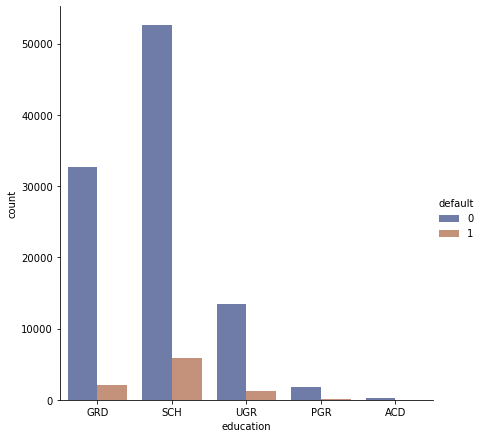

Процент дефолта по категории


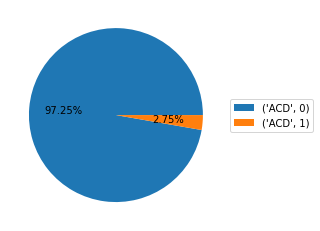

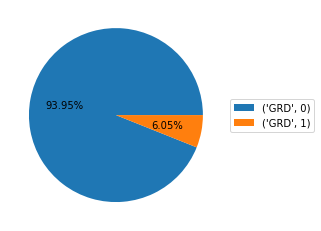

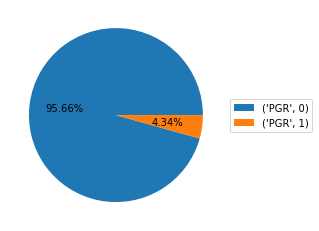

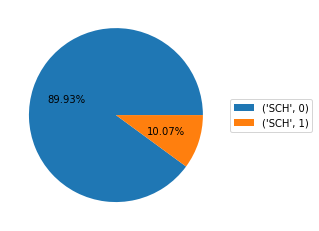

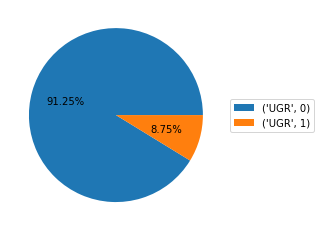

Признак -  home_address
Уникальные значения -  [1 2 3]
общее количество значений по группе
2    59591
1    48688
3     1869
Name: home_address, dtype: int64


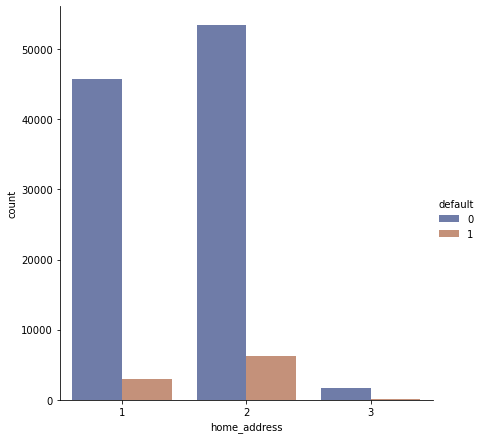

Процент дефолта по категории


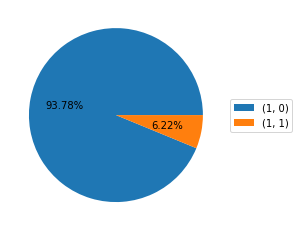

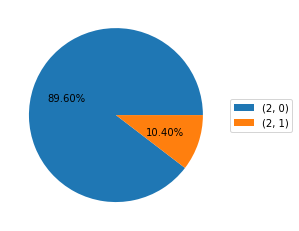

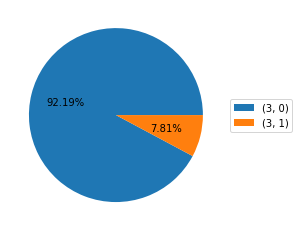

Признак -  work_address
Уникальные значения -  [2 3 1]
общее количество значений по группе
3    67113
2    30761
1    12274
Name: work_address, dtype: int64


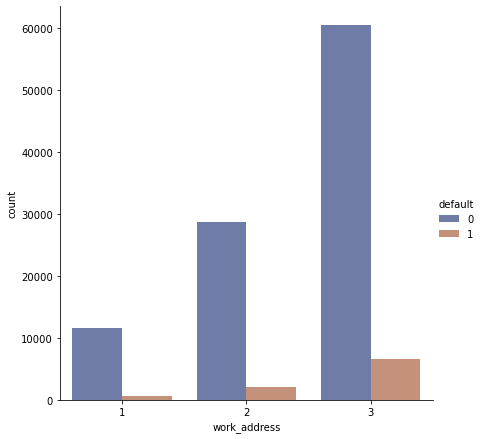

Процент дефолта по категории


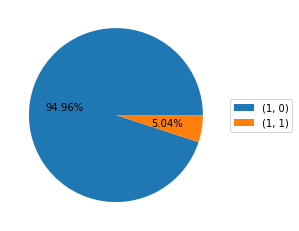

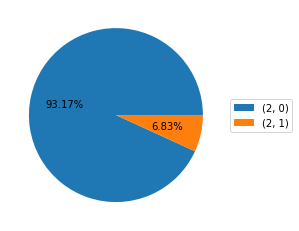

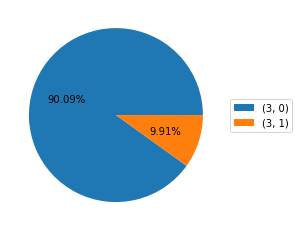

Признак -  sna
Уникальные значения -  [1 4 2 3]
общее количество значений по группе
1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64


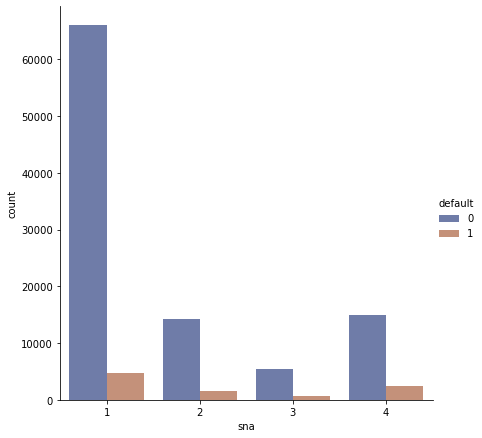

Процент дефолта по категории


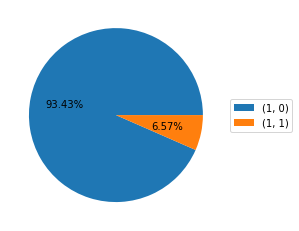

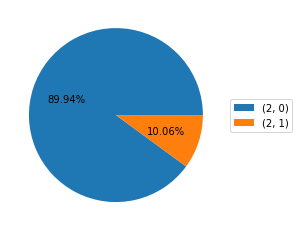

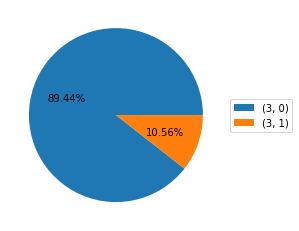

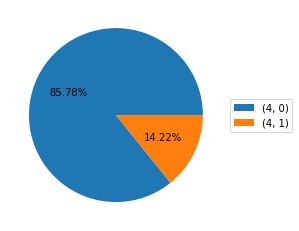

Признак -  first_time
Уникальные значения -  [4 3 1 2]
общее количество значений по группе
3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64


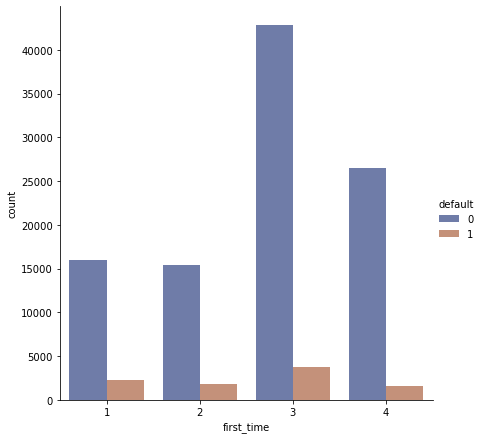

Процент дефолта по категории


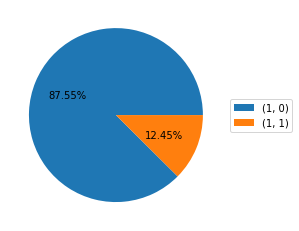

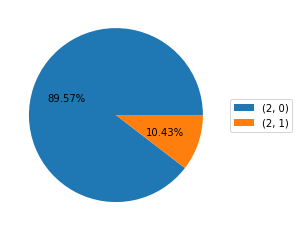

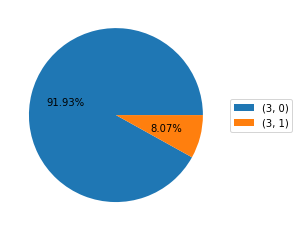

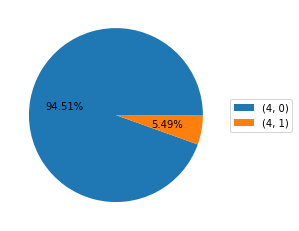

In [23]:
show_information(cat_cols)

## Вывод:   
Наблюдаем несбалансированность выборки по всем признакам. Пройдемся более 
подробно по каждому признаку.    
### Признак Education    
Самое популярное значение признака - SCH.     
Самый большой дефолт у значения SCH и UGR.
Весьма интересно, что у значений ACD и PGR весьма низкие показатели дефолта. Менее 5%.
### Признак home_address    
Самое популярное значение признака - 2.     
Самый большой дефолт у значения 3.    
Чем больше значение признака address, тем больше вероятность дефолта.
Так же у значения 1 вероятность дефолта - 6.22%
### Признак sna.    
Самое популярное значение признака - 1.    
Самый большой дефолт у значения 4 и 3.   
Чем больше значение признака sna, тем больше вероятность дефолта.   
Так же у значения 1 вероятность дефолта - 6.57%   
### Признак first_time.    
Самое популярное значение признака - 3.    
Самый большой дефолт у значения 1.   
Чем больше значение признака time, тем меньше вероятность дефолта.    
Так же у значения 4 вероятность дефолта меньше 5.49%   

# Раздел 5. Обработка количественных признаков.

In [24]:
print('количественные признаки', num_cols)

количественные признаки ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']


Немного изменим подход. Теперь будем анализировать каждую количественную переменную отдельно.

## Признак - age - возраст

вывод информации по признаку age
Мода -  31
count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64


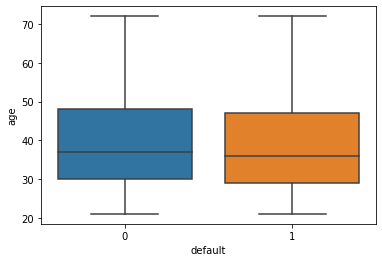

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


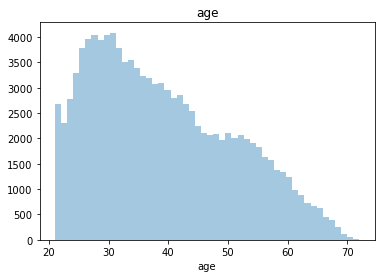

In [25]:
show_num_information(num_cols[0])

Вывод:    
Признак распределен не нормально. Есть правый хвост.  
Среди клиентов молодые люди чаще становятся дефолтными. Однако разница незначительная.

Создадим новый признак.    
0 - возраст до 30 - молодые люди.    
1 - возраст от 31 до 45  - люди средних лет.    
2 - возраст от 46 до 59  - престарелые люди.    
3 - возраст > 60 - пенсионеры.

In [26]:
df['age_type'] = df['age'].apply(lambda x:
                                 0 if x < 31 else 1 if x < 46 else 2 if x < 60 else 3)

In [27]:
# Проверим что получилось.
df['age_type'].value_counts()

1    46922
0    30798
2    26068
3     6360
Name: age_type, dtype: int64

In [28]:
# Добавим данный признак в список категориальных признаков
new_cat_cols.append('age_type')

## Признак decline_app_cnt - количество отказанных прошлых заявок

вывод информации по признаку decline_app_cnt
Мода -  0
count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64


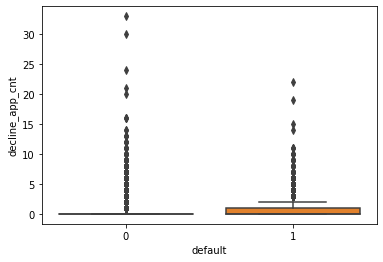

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


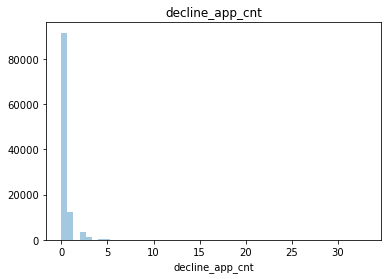

In [29]:
show_num_information(num_cols[1])

Вывод:    
Признак распределен не нормально. Есть очень тяжелый правый хвост.
Создадим новый признак.   
0-	Количество попыток = 0    
1-	Количество попыток от 1 до 5    
2-	Количество попыток больше 6

In [30]:
df['type_dec_app_cnt'] = df['decline_app_cnt'].apply(lambda x:
                                                     0 if x == 0 else 1 if x < 6 else 2)

In [31]:
# Проверим что получилось.
df['type_dec_app_cnt'].value_counts()

0    91471
1    18348
2      329
Name: type_dec_app_cnt, dtype: int64

In [32]:
# Добавим данный признак в список категориальных признаков
new_cat_cols.append('type_dec_app_cnt')

In [33]:
df['decline_app_cnt'] = df['decline_app_cnt'].apply(lambda x:
                                                    11 if x > 10 else x)

## Признак score_bki - скоринговый балл по данным из БКИ

вывод информации по признаку score_bki
Мода -  -1.77526279
count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64


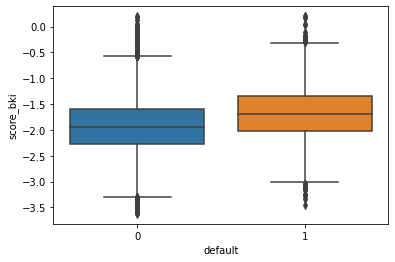

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


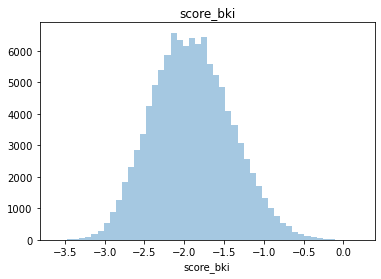

In [34]:
show_num_information(num_cols[2])

Вывод:    
Признак распределен нормально.   
На boxplot заметно влияние признака на предсказываемую переменную.

Добавим категориальную переменную type_score_bki. Разделим на 8 групп. Каждая группа содержит 1 стандартное отклонение начиная со среднего.

In [35]:
df['type_score_bki'] = df['score_bki'].apply(lambda x:
                                             8 if x <= -3.402726 else
                                             7 if x <= -2.903329 else
                                             6 if x <= -2.403932 else
                                             5 if x <= -1.904535 else
                                             4 if x <= -1.405138 else
                                             3 if x <= -0.905741 else
                                             2 if x <= -0.406344 else
                                             1 if x <= 0.093053 else
                                             0)

In [36]:
#Добавим данный признак в список категориальных признаков
new_cat_cols.append('type_score_bki')

## Признак bki_request_cnt - количество запросов в БКИ

вывод информации по признаку bki_request_cnt
Мода -  0
count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64


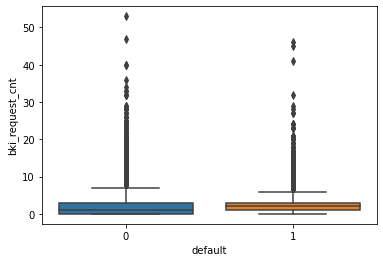

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


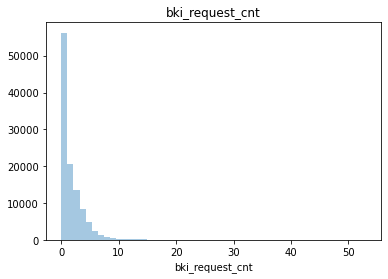

In [37]:
show_num_information(num_cols[3])

Вывод:    
Признак распределен не нормально. Есть очень тяжелый правый хвост.    
На boxplot заметно влияние признака на предсказываемую переменную.    
Так же. создадим новый признак, который будет отображать насколько много заявок подали люди от 1 до 3    
1 - если значение равно 0 или 1.    
2 - если значение от 0 до 3.     
3 - если значение от 3 до 5.    
4 - если значение больше 5.    
Так же у нас есть выбросы в данных. Всем значения больше 7 присвоим значение 7.

In [38]:
df['type_bki_request_cnt'] = df['bki_request_cnt'].apply(lambda x:
                                                         1 if x < 2 else
                                                         2 if x < 4 else
                                                         3 if x < 6 else
                                                         4)

In [39]:
df['bki_request_cnt'] = df['bki_request_cnt'].apply(
    lambda x: 7 if x > 7 else x)

In [40]:
# Добавим данный признак в список категориальных признаков
new_cat_cols.append('type_bki_request_cnt')

## Признак region_rating - рейтинг региона

вывод информации по признаку region_rating
Мода -  50
count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64


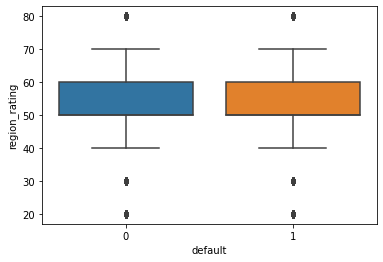

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


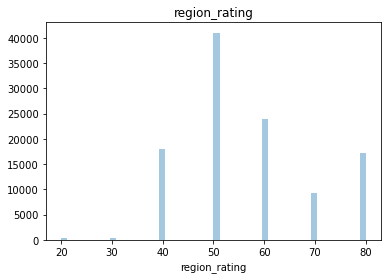

In [41]:
show_num_information(num_cols[4])

Признак распределен не нормально.    
На boxplot заметно влияние признака на предсказываемую переменную, однако возможно это из-за несбалансированности выборки.
Добавим категориальные переменные.     
0 - рейтинг 20    
1 - рейтинг 30    
2 - рейтинг 40    
3 - рейтинг 50    
4 - рейтинг 60    
5 - рейтинг 70    
6 - рейтинг 80

In [42]:
df['type_region_rating'] = df['region_rating'].apply(lambda x:
                                                     0 if x == 20 else
                                                     1 if x == 30 else
                                                     2 if x == 40 else
                                                     3 if x == 50 else
                                                     4 if x == 60 else
                                                     5 if x == 70 else
                                                     6
                                                     )

In [43]:
#Добавим данный признак в список категориальных признаков
new_cat_cols.append('type_region_rating')

## Признак income - доход заемщика

вывод информации по признаку income
Мода -  30000
count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64


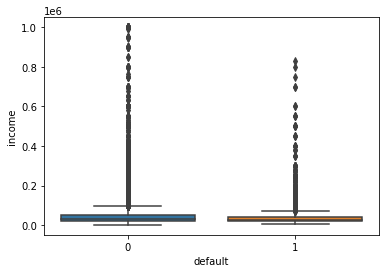

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


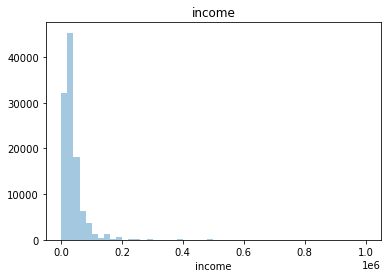

In [44]:
show_num_information(num_cols[5])

Признак распределен не нормально.    
На boxplot заметно влияние признака на предсказываемую переменную, однако возможно это из-за несбалансированности выборки. Данную теорию проверим позже.    
Так же создадим новый признак.    
 Тип дохода
1 если доход низкий. от 0 до 20 000.    
2 если доход средний. от 20 000 до 48 000.    
3 если доход высокий. Свыше 48 000.

In [45]:
df['type_income'] = df['income'].apply(lambda x:
                                       1 if x < 20001 else 2 if x < 48001 else 3)

In [46]:
#Добавим данный признак в список категориальных признаков
new_cat_cols.append('type_income')

# Раздел 6. Оценка корреляций и значимости непрерывных переменных

Воспользуемся критерием Пирсона для оценки корреляции.

In [47]:
cor_matrix = df.corr()

Сильная корреляция между age and age_type - 0.943921326402952
Сильная корреляция между decline_app_cnt and type_dec_app_cnt - 0.8277517925325357
Сильная корреляция между score_bki and type_score_bki - -0.9606735499391839
Сильная корреляция между bki_request_cnt and type_bki_request_cnt - 0.962648868877561
Сильная корреляция между region_rating and type_region_rating - 0.9999999999999876
Сильная корреляция между home_address and work_address - 0.7265354508767263
Сильная корреляция между income and type_income - 0.5747601207540561
Сильная корреляция между sna and first_time - -0.5265943387583837


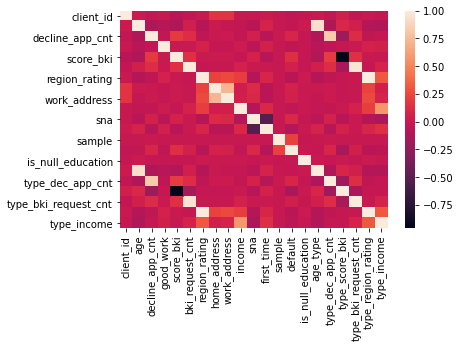

In [48]:
print_corr_matrix(cor_matrix)

С целевой переменной сильной корреляции нету. Однако есть сильная зависимость между нашими созданными категориальными переменными и их родителями.    
Обнаружена сильная корреляция между home_address and work_address. Можно предположить, что большинство людей работают рядом со своим местом работы.    
И обнаружена корреляция между sna  and first_time. 

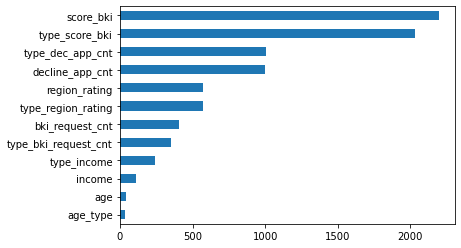

In [49]:
print_f_classif(df, num_cols+new_cat_cols)

Самый влиятельный признак - скоринговый балл по данным из БКИ. В целом логично, чем лучше у тебя кредитный рейтинг - тем более вероятно, что тебе дадут кредит.    

 # Раздел 7 кодирование категориальных и бинарных признаков.

Выполним пару простых операций по преобразованию наших данных.

In [50]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
df['education'] = label_encoder.fit_transform(df['education'])
    # убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,is_null_education,age_type,type_dec_app_cnt,type_score_bki,type_bki_request_cnt,type_region_rating,type_income
0,74835,22MAR2014,1,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0,0,0,0,5,2,3,3
1,17527,24JAN2014,3,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0,0,1,1,4,2,3,1
2,75683,23MAR2014,4,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0,0,2,0,4,1,3,2
3,26883,03FEB2014,3,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0,0,2,0,5,1,2,1
4,28862,04FEB2014,1,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,0,0,1,0,6,1,6,3


# Раздел 8. Оценка значимости категориальных и бинарных признаков.

<AxesSubplot:>

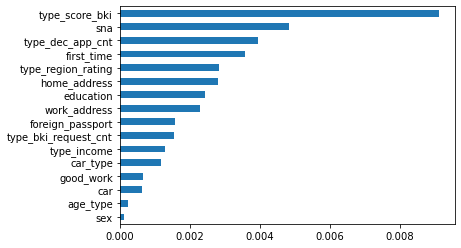

In [51]:
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols + new_cat_cols],
                                        df['default'], discrete_features=True),
                                        index=bin_cols + cat_cols + new_cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Самый значительный признак SNA (связь заемщика с клиентами банка).    
Значит, если у банка хорошие взаимоотношение с клиентом, тем более вероятно он выдаст кредит.    
Второй самый значительный признак - type_dec_app_cnt (тип количества отказов прошлых заявок). В целом и родитель этого признака, тоже хорошо себя показал на предыдущем анализе.    
Так же видим, что созданные нами переменные тоже неплохо влияют на предсказываемое значение.

In [52]:
# после удалим признак work_address т.к. сильная корреляция с home_address
col_for_drop.append('work_address') 

# Раздел 10. Обработка даты

In [53]:
# Преобразуем дату в понятный для компьютера вид.
df.app_date = df.app_date.apply(lambda x: datetime.strptime(x, '%d%b%Y'))

In [54]:
# Добавим новые признаки, месяц, день недели, день месяца и отметим выходные дни.
df['day'] = df.app_date.apply(lambda x: int(x.day))
df['month'] = df.app_date.apply(lambda x: int(x.month))
df['weekday'] = df.app_date.apply(lambda x: int(x.weekday()))
df['is_weekend'] = df.app_date.apply(lambda x: 1 if x in [5, 6] else 0)
# Добавим признак в очередь на удаление.
col_for_drop.append('app_date')

 # Раздел 11 future engineering

Преобразуем признак car и car_type в общий признак.     
0 - нет машины    
1 - есть машина    
2 - есть импортная машины

In [56]:
df['car+car_type'] = df.apply(lambda x: x['car'] + x['car_type'], axis=1)

In [57]:
col_for_drop.append('car_type')
col_for_drop.append('car')

In [55]:
# добавим новый признак score_bki*region_rating
# Данные признак вывели после череды экспериментов.
df['score_bki*region_rating'] = df.apply(
    lambda x: x['score_bki'] * x['region_rating'], axis=1)

### По каждому признаку их col_for_analytics выделим средние, максимальные и минимальные значения 'score_bki', 'bki_request_cnt', 'income'. После вычтем каждое значение от среднего.

In [58]:
col_for_analytics = ['education', 'sex', 'age_type', 'car+car_type',
                     'good_work', 'home_address', 'type_region_rating']

In [59]:
num_cols_2 = [] # сюда сохраним созданные нами признаки

Можно идти пить чай, следующая функция работает долго.

In [60]:
for i in col_for_analytics:
    print(f'Начало работы над {i}')
    mean_income = df.groupby(i)['income'].mean().to_dict()
    min_income = df.groupby(i)['income'].min().to_dict()
    max_income = df.groupby(i)['income'].max().to_dict()

    mean_bki_request_cnt = df.groupby(i)['bki_request_cnt'].mean().to_dict()
    min_bki_request_cnt = df.groupby(i)['bki_request_cnt'].min().to_dict()
    max_bki_request_cnt = df.groupby(i)['bki_request_cnt'].max().to_dict()

    mean_score_bki = df.groupby(i)['score_bki'].mean().to_dict()
    min_score_bki = df.groupby(i)['score_bki'].min().to_dict()
    max_score_bki = df.groupby(i)['score_bki'].max().to_dict()
############################################################################
    df[i + '_mean_income'] = df[i].map(mean_income)
    df[i + 'min_income'] = df[i].map(min_income)
    df[i + 'max_income'] = df[i].map(max_income)
    df[i + '-mean_income'] = df.apply(lambda x:
                                      x['income'] - x[i + '_mean_income'],
                                      axis=1)

    num_cols_2.append(i + '_mean_income')
    num_cols_2.append(i + 'min_income')
    num_cols_2.append(i + 'max_income')
    num_cols_2.append(i + '-mean_income')
    #########################################################################
    df[i + 'mean_bki_request_cnt'] = df[i].map(mean_bki_request_cnt)
    df[i + 'min_bki_request_cnt'] = df[i].map(min_bki_request_cnt)
    df[i + 'max_bki_request_cnt'] = df[i].map(max_bki_request_cnt)
    df[i + '-mean_bki_request_cnt'] = df.apply(lambda x:
                                               x['bki_request_cnt'] -
                                               x[i + 'mean_bki_request_cnt'],
                                               axis=1)

    num_cols_2.append(i + 'mean_bki_request_cnt')
    num_cols_2.append(i + 'min_bki_request_cnt')
    num_cols_2.append(i + 'max_bki_request_cnt')
    num_cols_2.append(i + '-mean_bki_request_cnt')
 ##########################################################################
    df[i + 'mean_score_bki'] = df[i].map(mean_score_bki)
    df[i + 'min_score_bki'] = df[i].map(min_score_bki)
    df[i + 'max_score_bki'] = df[i].map(max_score_bki)
    df[i + '-mean_score_bki'] = df.apply(lambda x:
                                         x['score_bki'] -
                                         x[i + 'mean_score_bki'],
                                         axis=1)

    num_cols_2.append(i + 'mean_score_bki')
    num_cols_2.append(i + 'min_bki_request_cnt')
    num_cols_2.append(i + 'max_score_bki')
    num_cols_2.append(i + '-mean_score_bki')
    print(f'Конец работы над {i}')
print("Конец")

Начало работы над education
Конец работы над education
Начало работы над sex
Конец работы над sex
Начало работы над age_type
Конец работы над age_type
Начало работы над car+car_type
Конец работы над car+car_type
Начало работы над good_work
Конец работы над good_work
Начало работы над home_address
Конец работы над home_address
Начало работы над type_region_rating
Конец работы над type_region_rating
Конец


# Раздел 12. Нормализация и логарифмирование непрерывных переменных.

In [93]:
df_end = df.copy()

In [94]:
# удалим все ненужные признаки.
df_end.drop(col_for_drop, axis = 1, inplace = True)
# признак ниже преобразован в категориальный. 
# поэтому для сокращения размерности матрицы, удалим его.
df_end.drop(num_cols, axis = 1, inplace = True)

Нормализуем численные переменные, для улучшения работы алгоритма.

In [95]:
num_cols_2.append('score_bki*region_rating')

In [96]:
for column in num_cols_2:
    df_end[column] = StandardScaler().fit_transform(df_end[num_cols_2])

    # убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,is_null_education,age_type,type_dec_app_cnt,type_score_bki,type_bki_request_cnt,type_region_rating,type_income,day,month,weekday,is_weekend,score_bki*region_rating,car+car_type,education_mean_income,educationmin_income,educationmax_income,education-mean_income,educationmean_bki_request_cnt,educationmin_bki_request_cnt,educationmax_bki_request_cnt,education-mean_bki_request_cnt,educationmean_score_bki,educationmin_score_bki,educationmax_score_bki,education-mean_score_bki,sex_mean_income,sexmin_income,sexmax_income,sex-mean_income,sexmean_bki_request_cnt,sexmin_bki_request_cnt,sexmax_bki_request_cnt,sex-mean_bki_request_cnt,sexmean_score_bki,sexmin_score_bki,sexmax_score_bki,sex-mean_score_bki,age_type_mean_income,age_typemin_income,age_typemax_income,age_type-mean_income,age_typemean_bki_request_cnt,age_typemin_bki_request_cnt,age_typemax_bki_request_cnt,age_type-mean_bki_request_cnt,age_typemean_score_bki,age_typemin_score_bki,age_typemax_score_bki,age_type-mean_score_bki,car+car_type_mean_income,car+car_typemin_income,car+car_typemax_income,car+car_type-mean_income,car+car_typemean_bki_request_cnt,car+car_typemin_bki_request_cnt,car+car_typemax_bki_request_cnt,car+car_type-mean_bki_request_cnt,car+car_typemean_score_bki,car+car_typemin_score_bki,car+car_typemax_score_bki,car+car_type-mean_score_bki,good_work_mean_income,good_workmin_income,good_workmax_income,good_work-mean_income,good_workmean_bki_request_cnt,good_workmin_bki_request_cnt,good_workmax_bki_request_cnt,good_work-mean_bki_request_cnt,good_workmean_score_bki,good_workmin_score_bki,good_workmax_score_bki,good_work-mean_score_bki,home_address_mean_income,home_addressmin_income,home_addressmax_income,home_address-mean_income,home_addressmean_bki_request_cnt,home_addressmin_bki_request_cnt,home_addressmax_bki_request_cnt,home_address-mean_bki_request_cnt,home_addressmean_score_bki,home_addressmin_score_bki,home_addressmax_score_bki,home_address-mean_score_bki,type_region_rating_mean_income,type_region_ratingmin_income,type_region_ratingmax_income,type_region_rating-mean_income,type_region_ratingmean_bki_request_cnt,type_region_ratingmin_bki_request_cnt,type_region_ratingmax_bki_request_cnt,type_region_rating-mean_bki_request_cnt,type_region_ratingmean_score_bki,type_region_ratingmin_score_bki,type_region_ratingmax_score_bki,type_region_rating-mean_score_bki
0,74835,2014-03-22,1,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0,0,0,0,5,2,3,3,22,3,5,0,-113.594183,2,54315.008916,1000,1000000,-4315.008916,2.018983,0,7,0.981017,-1.920431,-3.624586,0.199773,-0.351453,50902.634542,2000,1000000,-902.634542,1.794420,0,7,1.205580,-1.930645,-3.624586,0.199773,-0.341239,37549.644490,1000,950000,12450.355510,1.761608,0,7,1.238392,-1.828189,-3.455709,0.199773,-0.443695,69478.156417,1000,1000000,-19478.156417,1.878665,0,7,1.121335,-1.947850,-3.624586,0.199773,-0.324034,40477.925204,1000,1000000,9522.074796,1.900834,0,7,1.099166,-1.905661,-3.624586,0.199773,-0.366222,38952.375801,1000,1000000,11047.624199,1.903036,0,7,1.096964,-1.914808,-3.574197,0.199773,-0.357076,35042.573583,1000,1000000,14957.426417,1.901906,0,7,1.098094,-1.914400,-3.597981,0.199773,-0.357484
1,17527,2014-01-24,3,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0,0,1,1,4,2,3,1,24,1,4,0,-75.249957,0,32149.392606,1000,1000000,-27149.392606,1.889869,0,7,0.110131,-1.904309,-3.559133,0.198070,0.399310,33285.677130,1000,1000000,-28285.677130,1.997138,0,7,0.002862,-1.884135,-3.597981,0.199773,0.379136,45100.755019,1000,1000000,-40100.755019,1.888986,0,7,0.111014,-1.915606,-3.624586,0.199773,0.410606,33153.865554,1000,1000000,-28153.865554,1.958487,0,7,0.041513,-1.889588,-3.597981,0.199773,0.384589,40477.925204,1000,1000000,-35477.925204,1.900834,0,7,0.099166,-1.905661,-3.624586,0.199773,0.400662,38952.375801,1000,1000000,-33952.375

Для того чтобы сделать распределение данных переменных более нормальным, будем работать с логарифмированными величинами этих переменных. Тогда мы сможем избежать чувствительности к сильным отклонениям в суммах у линейных моделей. А также это позволит улучшить процесс создание признаков и убрать ошибку при работе с большими величинами.

In [97]:
# логарифмирование
for i in num_cols_2 :
    df_end[i] = df_end[i].apply(lambda x: math.log(10+x))

# Раздел 13. Построение модели

In [98]:
# Отметим все бинарные и категориальные переменные
code_col = ['education', 'home_address', 'first_time', 'age_type', 'type_dec_app_cnt', 'type_score_bki',
            'type_bki_request_cnt', 'type_region_rating', 'type_income', 'car+car_type']

In [99]:
df_end = pd.get_dummies(df_end, prefix=code_col, columns=code_col)

In [100]:
# выделим трейн и тест
df_train = df_end[df_end['sample'] == 1].drop('sample', axis=1)
df_test = df_end[df_end['sample'] == 0].drop('sample', axis=1)

In [101]:
X = df_train.drop('default', axis=1).iloc[:, 1:]
Y = df_train['default']
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)

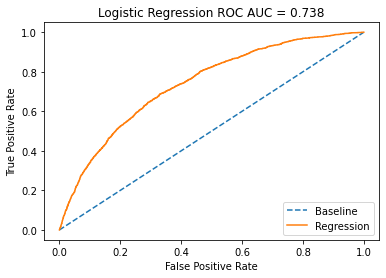

In [139]:
# обучим модель и построим сразу roc_curve
model = LogisticRegression(C=0.1, solver='liblinear', random_state = 42)
model.fit(X_train, y_train)
# X_test y_test
probs = model.predict_proba(X_test)
probs = probs[:, 1]

print_roc_curve(y_test, probs)

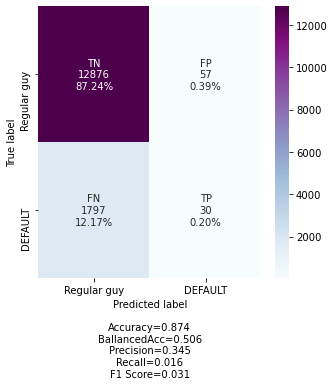

In [103]:
y_bin_pred = model.predict(X_test)
categories = ['Regular guy', 'DEFAULT']
cf_matrix = confusion_matrix(y_test, y_bin_pred)
make_confusion_matrix(cf_matrix, categories=categories, sum_stats=True)

# Выводы по работе

В целом удалось увеличить показатели Roc AUC с 0.584 до 0.738.
Однако показатель Accuracy упал с 0,876 до 0.874, что значит наша модель стала допускать больше ошибок при обнаружении не дефолтных клиентов.
Весьма интересно, что Balanced Accuracy увеличилась всего на 0,006.
Наша модель все ещё недостаточно хорошо определяет дефолтных клиентов, поэтому есть куда расти.

Самый большой прирост метрики roc_auc замечен после применения one hot encoding, а также добавления новых признаков - минимум, максиму, среднее по группам и разница между средним.

Отметим, что два самых важных признака для построения модели - sna (связь заемщика с клиентами банка) и score_bki (скоринговый балл по данным из БКИ).
Поэтому, всегда пользуйтесь одним банком, берите там кредиты и погашайте их вовремя, для повышения score_ bki.


# Вариант логистической регрессии с автопобором гиперпараметров
params = {
    'C' : np.logspace(0, 4, 10),
    'solver' : ['liblinear', 'sag', 'saga']
}

model = LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=4)
model.fit(X_train, y_train)

clf = GridSearchCV(model, params, cv=3, verbose=3)

best_model = clf.fit(X_train, y_train)

print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Лучшее solver:', best_model.best_estimator_.get_params()['solver'])

# Готовим к решение к сабмиту

In [ ]:
X_2 = df_test.drop('default', axis = 1).iloc[:,1:]
y_pred = model.predict_proba(X_2)
results_df = pd.DataFrame(data={'client_id':df_test['client_id'], 'default':y_pred[:,1]})
results_df.to_csv('submission.csv', index=False)
results_df